In [1]:
##### Step 1: import functions #####
from keras.layers import Dense, Flatten, BatchNormalization, Activation, Conv2D, AveragePooling2D, Input
from keras.layers import MaxPooling2D, Dropout
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
import pickle
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import keras as keras
keras.utils.set_random_seed(123)
from sklearn.metrics import roc_curve, auc
from six import StringIO 
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from scipy.stats import ttest_ind
from IPython.display import Image  
import pydotplus
from keras.regularizers import L1L2
import os

In [2]:
os.chdir('../')

In [3]:
#load data
allData = pickle.load( open( "DL_CyTOF/Bioheart_combined_allData.obj", "rb" ) )
metaData = allData["cytof_files"]
cytoData = allData["expr_list"]
markerNames = allData["marker_names"]

# inspect the data
print("\nFirst 5 rows of metaData: ")
print(metaData.head(),"\n")

print("Dimensions of cytoData: ",cytoData.shape,"\n")
print("Names of the 27 makers: \n",markerNames.values)


First 5 rows of metaData: 
   sample_id  Gensini_bin               file_name   data
0         87            1  Bioheart_sample_87.fcs  train
1         88            1  Bioheart_sample_88.fcs  train
2         89            1  Bioheart_sample_89.fcs  train
3         92            1  Bioheart_sample_92.fcs  train
4         96            1  Bioheart_sample_96.fcs  train 

Dimensions of cytoData:  (169, 10000, 27, 1) 

Names of the 27 makers: 
 ['HLA_DR' 'CD3' 'CD4' 'CD8A' 'CD25' 'CD127' 'FOXP3' 'CD27' 'KLRG1' 'CD56'
 'CD45RO' 'CD45RA' 'CD192_CCR2' 'CD194_CCR4' 'CD196_CCR6' 'CD39' 'CD38'
 'KI67' 'CD183_CXCR3' 'CCR7' 'CD19' 'CD20' 'IGD' 'CD14' 'CD304' 'CD141'
 'CD1C_PE']


In [4]:
##### Step 3: split train, validation and test######
y = metaData.Gensini_bin.values
x = cytoData

train_id = metaData.data =="train"
test_id = metaData.data =="test"

x_train = x[train_id]; y_train = y[train_id]
# x_valid = x[valid_id]; y_valid = y[valid_id]
x_test = x[test_id]; y_test = y[test_id]

In [5]:
# input
model_input = Input(shape=x_train[0].shape)

# first convolution layer
model_output = Conv2D(3, kernel_size=(1, x_train.shape[2]),
                 activation=None)(model_input)
model_output = BatchNormalization()(model_output)
model_output = Activation("relu")(model_output)

# sceond convolution layer
model_output = Conv2D(3, (1, 1), activation=None)(model_output)
model_output = BatchNormalization()(model_output)
model_output = Activation("relu")(model_output)

# pooling layer
model_output = AveragePooling2D(pool_size=(x_train.shape[1], 1))(model_output)
model_output = Flatten()(model_output)

# Dense layer
model_output = Dense(3, activation=None)(model_output)
model_output = BatchNormalization()(model_output)
model_output = Activation("relu")(model_output)

# output layer
model_output = Dense(1, activation=None)(model_output)
model_output = BatchNormalization()(model_output)
model_output = Activation("sigmoid")(model_output)

In [6]:
##### Step 5: Fit model #####
# specify input and output
model = Model(inputs=[model_input],
              outputs=model_output)

# define loss function and optimizer
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.01),
              metrics=['accuracy'])

# save the best performing model
checkpointer = ModelCheckpoint(filepath='DL_CyTOF/bioheart_saved_weights.hdf5', 
                               monitor='val_loss', verbose=1, 
                               save_best_only=True)
earlyStop = EarlyStopping(monitor='val_loss', patience=100, mode='auto')

# model training
model.fit([x_train], y_train,
          batch_size=60,
          epochs=200, 
          verbose=1,
          callbacks=[checkpointer, earlyStop],
          validation_split=0.3)

Epoch 1/200


/opt/anaconda3/envs/CyTOF_DL/lib/python3.11/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2024-12-12 14:54:57.138064: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/2 [==============>...............] - ETA: 0s - loss: 0.8717 - accuracy: 0.4167
Epoch 1: val_loss improved from inf to 0.69068, saving model to DL_CyTOF/bioheart_saved_weights.hdf5
2/2 [==============================] - 1s 141ms/step - loss: 0.8765 - accuracy: 0.4156 - val_loss: 0.6907 - val_accuracy: 0.5882
Epoch 2/200
1/2 [==============>...............] - ETA: 0s - loss: 0.7745 - accuracy: 0.5000
Epoch 2: val_loss improved from 0.69068 to 0.68841, saving model to DL_CyTOF/bioheart_saved_weights.hdf5
2/2 [==============================] - 0s 45ms/step - loss: 0.7937 - accuracy: 0.4805 - val_loss: 0.6884 - val_accuracy: 0.5882
Epoch 3/200
1/2 [==============>...............] - ETA: 0s - loss: 0.7196 - accuracy: 0.5333
Epoch 3: val_loss improved from 0.68841 to 0.68531, saving model to DL_CyTOF/bioheart_saved_weights.hdf5
2/2 [==============================] - 0s 43ms/step - loss: 0.7614 - accuracy: 0.4935 - val_loss: 0.6853 - val_accuracy: 0.5882
Epoch 4/200
1/2 [==============>.....

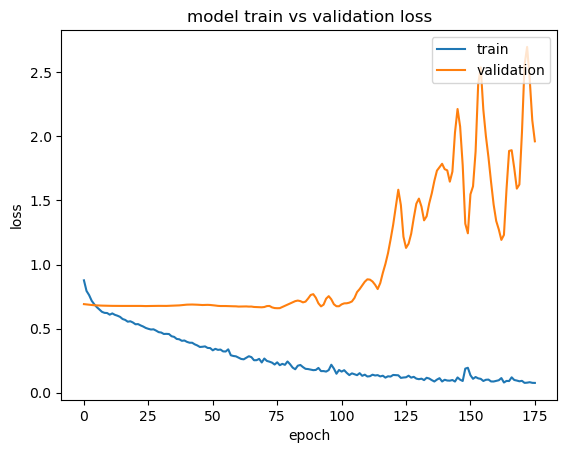

In [7]:
# plot train and validation loss
#model.save('result_11_weights.hdf5')

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [8]:
best_model = load_model('DL_CyTOF/bioheart_saved_weights.hdf5')

# print result of the best model
score = best_model.evaluate([x_train], y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

# score = best_model.evaluate([x_valid], y_valid, verbose=0)
# print('Valid loss:', score[0])
# print('Valid accuracy:', score[1])

score = best_model.evaluate([x_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.5993364453315735
Train accuracy: 0.6936936974525452
Test loss: 0.7765840888023376
Test accuracy: 0.48275861144065857


2/2 [==============================] - 0s 7ms/step


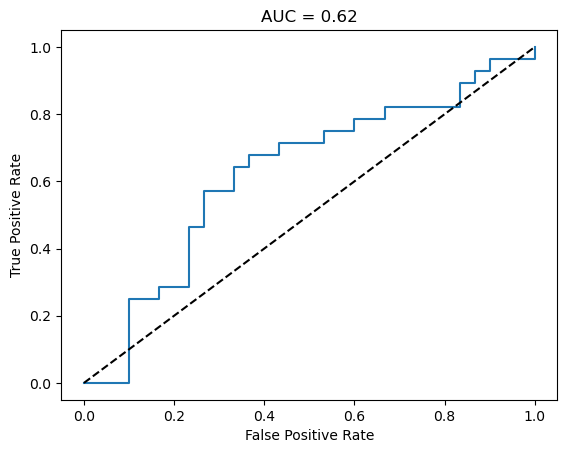

In [9]:
# generate ROC and AUC
y_scores = best_model.predict([x_test])
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC = {0:.2f}'.format(roc_auc))
plt.show()

In [10]:
y_scores = pd.DataFrame(np.column_stack([list(y_test), list(y_scores.flatten())]), columns=['truth', 'pred'])
y_scores.to_csv('data/bioheart_deep_cytof_aucs.csv', sep=',')

## Fit Cell CNN

In [17]:
##### define model #####
coeff_l1 = 0
coeff_l2 = 1e-4
model_input = Input(shape=x_train[0].shape)
model_output = Conv2D(5, kernel_size=(1, x_train.shape[2]),
                 activation='linear', 
                      kernel_regularizer=L1L2(l1=coeff_l1, l2=coeff_l2))(model_input)
model_output = Activation("relu")(model_output)

model_output = MaxPooling2D(pool_size=(10000, 1))(model_output)
model_output = Flatten()(model_output)

model_output = Dense(1, activation=None, kernel_regularizer=L1L2(l1=coeff_l1, l2=coeff_l2))(model_output)
model_output = Activation("sigmoid")(model_output)

model = Model(inputs=[model_input],
                           outputs=model_output)
model.compile(loss='binary_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='DL_CyTOF/bioheart_cell_cnn_saved_weights.hdf5', monitor='val_loss', 
                                               verbose=0, save_best_only=True)
earlyStop = EarlyStopping(monitor='val_loss', patience=100, 
                                          verbose=1, mode='auto', baseline=None, restore_best_weights=True)

/opt/anaconda3/envs/CyTOF_DL/lib/python3.11/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:
# model training
model.fit([x_train], y_train,
          batch_size=60,
          epochs=200, 
          verbose=1,
          callbacks=[checkpointer, earlyStop],
          validation_split=0.3)

Epoch 1/200
2/2 [==============================] - 0s 66ms/step - loss: 1.4974 - accuracy: 0.2727 - val_loss: 1.1491 - val_accuracy: 0.4118
Epoch 2/200
2/2 [==============================] - 0s 28ms/step - loss: 1.3796 - accuracy: 0.2727 - val_loss: 1.0693 - val_accuracy: 0.4118
Epoch 3/200
2/2 [==============================] - 0s 28ms/step - loss: 1.2655 - accuracy: 0.2727 - val_loss: 0.9969 - val_accuracy: 0.4118
Epoch 4/200
2/2 [==============================] - 0s 27ms/step - loss: 1.1633 - accuracy: 0.2727 - val_loss: 0.9312 - val_accuracy: 0.4118
Epoch 5/200
2/2 [==============================] - 0s 28ms/step - loss: 1.0647 - accuracy: 0.2727 - val_loss: 0.8741 - val_accuracy: 0.4118
Epoch 6/200
2/2 [==============================] - 0s 28ms/step - loss: 0.9797 - accuracy: 0.2727 - val_loss: 0.8255 - val_accuracy: 0.4118
Epoch 7/200
2/2 [==============================] - 0s 28ms/step - loss: 0.9082 - accuracy: 0.2597 - val_loss: 0.7871 - val_accuracy: 0.4118
Epoch 8/200
2/2 [===

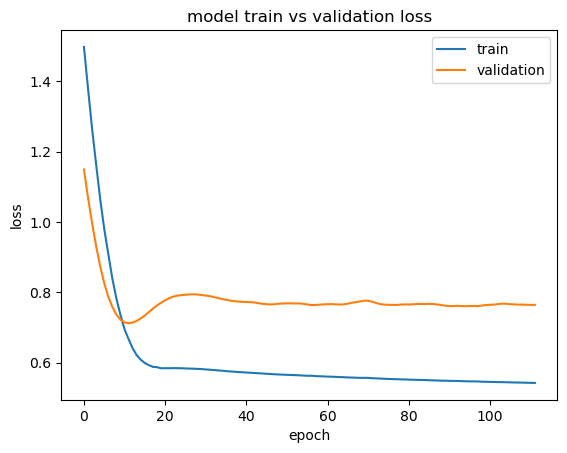

In [19]:
# plot train and validation loss
#model.save('result_11_weights.hdf5')

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [20]:
best_model = load_model('DL_CyTOF/bioheart_cell_cnn_saved_weights.hdf5')

# print result of the best model
score = best_model.evaluate([x_train], y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

# score = best_model.evaluate([x_valid], y_valid, verbose=0)
# print('Valid loss:', score[0])
# print('Valid accuracy:', score[1])

score = best_model.evaluate([x_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.6631864309310913
Train accuracy: 0.6576576828956604
Test loss: 0.6812885999679565
Test accuracy: 0.5517241358757019


2/2 [==============================] - 0s 4ms/step


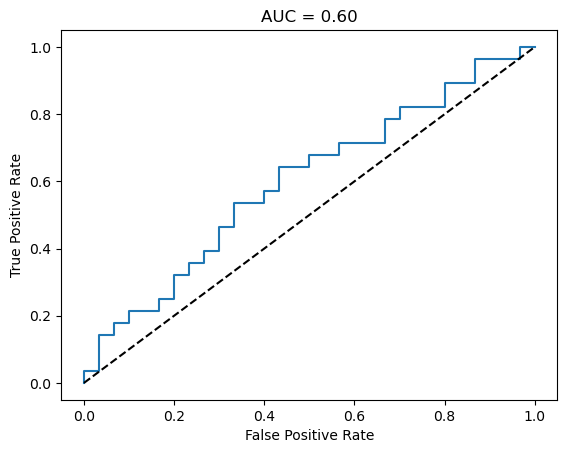

In [21]:
# generate ROC and AUC
y_scores = best_model.predict([x_test])
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC = {0:.2f}'.format(roc_auc))
plt.show()

In [22]:
y_scores = pd.DataFrame(np.column_stack([list(y_test), list(y_scores.flatten())]), columns=['truth', 'pred'])
y_scores.to_csv('data/bioheart_cell_cnn_aucs.csv', sep=',')